# Subgraph Localization

**Author**: Amit Boyarski & Dani Kogan

## Intro

Let $\mathcal{G}$ be a graph with $n$ nodes, possibly directed, and let $\mathcal{G}_{sub}$ be another graph with $m<n$ nodes. 
Our problem is to find a subgraph of $\mathcal{G}$ which is as close as possible to $\mathcal{G}_{sub}$ according to some graph similarity metric $d(\mathcal{G}, \mathcal{G}_{sub})$.  For example, if $\mathcal{G}_{sub}$ consists of a subset of edges of $\mathcal{G}$ and their incident nodes, the problem is to identify those edges (from which the nodes could be identified). 

For simplicity we shall phrase the problem in terms of directly identifying the nodes rather than the edges. Any node identification algorithm can be turned into an edge identification algorithm by applying it to the *line graphs* of $\mathcal{G}$ and $\mathcal{G}_{sub}$.  We also phrase the algorithm in terms of undirected graphs. In order to account for the direction, we apply an invertible symmetrization to the graphs as a pre-process, e.g., transforming the directed graph into an undirected bipartite graph.
 
Let $\mathbf{w}$ denote a discrete probability distribution on the nodes of  $\mathcal{G}$, i.e., $0\leq w_i \leq 1$ satisfying $\sum_{i=1}^{n}{w_i} = 1$ is the probability for sampling the node $i$.  A vector $\mathbf{w}_{sub}$ representing the nodes of $\mathcal{G}_{sub}$ would be a uniform distribution on the nodes of $\mathcal{G}$ that is concentrated on the nodes of $\mathcal{G}_{sub}$, i.e., 

$$
\mathbf{w}_{sub}[i] = \begin{cases} 1/m &\;\;\;\;  i\in \mathcal{N}(\mathcal{G}_{sub})\\
 0 & \;\;\;\;otherwise.
 \end{cases}
$$
 
In order to optimize for $\mathbf{w}$, we define two functions:

- A node classification function $\texttt{classify}$ parametrized by $\theta$, which generates a vector $\mathbf{w}$ from $\mathcal{G}, \mathcal{G}_{sub}$, i.e.
$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub}; \theta)
$$

- A permutation invariant graph embedding function $\texttt{embed}$ parametrized by $\mathbf{\phi}$ which satisfies the following condition:

$$
$d\left(\texttt{embed}(\mathcal{G}, \mathbf{w}_{sub} ; \phi), $\texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1} ; \phi)\right) \approx 0  
$$

Our complete algorithm consists of two steps:

- *Training* : Shaping the graph metric 

$$
d\left(\texttt{embed}(\mathcal{G}_1, \mathbf{w}_1 ; \phi), $\texttt{embed}(\mathcal{G}_2, \mathbf{w}_2 ; \phi)\right)
$$

via supervised learning, e.g., learning $\phi$ via contrastive learning.

- *Inference*: Optimizing for $\theta$ given $\phi$:

$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub} ; \theta)\\
\mathbf{v} = \texttt{embed}(\mathcal{G}, \mathbf{w}, ; \phi)\\
\mathbf{v}_{sub} = \texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1}, ; \phi)
$$

$$
\min_{\theta} d(\mathbf{v},\mathbf{v}_{sub})^2 + \rho \cdot \texttt{reg}(\mathcal{G}, \mathbf{w})
$$

The purpose of the $\texttt{reg}$ function is to promote $\mathbf{w}$ to be piecewise constant on the graph.

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    nn_subgraph_localization
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import \
    EmbeddingMetricNetwork
from subgraph_matching_via_nn.composite_nn.composite_nn import CompositeNeuralNetwork
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_networks import \
    NNNodeClassifierNetwork, IdentityNodeClassifierNetwork, GCNNodeClassifierNetwork
from subgraph_matching_via_nn.utils.utils import uniform_dist, NP_DTYPE, TORCH_DTYPE
from subgraph_matching_via_nn.graph_embedding_networks.graph_embedding_nn import \
    MomentEmbeddingNetwork, SpectralEmbeddingNetwork
import torch
from subgraph_matching_via_nn.utils.utils import plot_degree_distribution, \
    plot_graph_with_colors
from subgraph_matching_via_nn.utils.utils import plot_indicator
from torch import tensor
import kmeans1d
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor
from subgraph_matching_via_nn.data.data_loaders import load_graph
from subgraph_matching_via_nn.data.paths import *
from subgraph_matching_via_nn.utils.graph_utils import laplacian

plt.rcParams["figure.figsize"] = (6, 3)  # Set the desired figure size (width, height)


In [27]:
from subgraph_matching_via_nn.utils.graph_utils import graph_edit_matrix
from subgraph_matching_via_nn.data.paths import DATA_PATH

# Set the size of the graph and the subgraph
n = 15  # Number of nodes in the graph (for random graph)
m = 7  # Number of nodes in the subgraph (for random graph)
seed = 10  # for plotting
loader_params = {'graph_size': n,
                 'subgraph_size': m,
                 'data_path': DATA_PATH,
                 'g_full_path': COMP2_FULL_path,
                 'g_sub_path': COMP2_SUB0_path}

G, G_sub, w_indicator, edge_indicator = \
    load_graph(type='random',
               loader_params=loader_params)  # type = 'random', 'example', 'subcircuit'



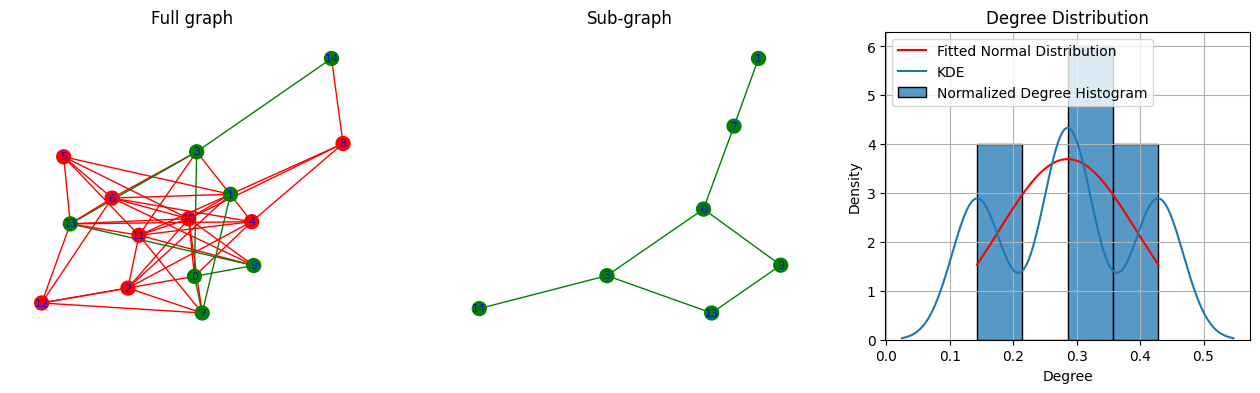

First 4 moments: ['0.2857', '0.0933', '0.0333', '0.0126', '0.0050', '0.0020']


In [28]:

# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G=G, distribution=edge_indicator, ax=axes[0],
                       colorbar=False, title='Full graph', seed=seed, draw_labels=True)
plot_graph_with_colors(G=G_sub, ax=axes[1], colorbar=False,
                       title='Sub-graph', seed=seed, draw_labels=True)
# Plot degree distribution and compute first 4 moments
n_moments = 6
moments = plot_degree_distribution(G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

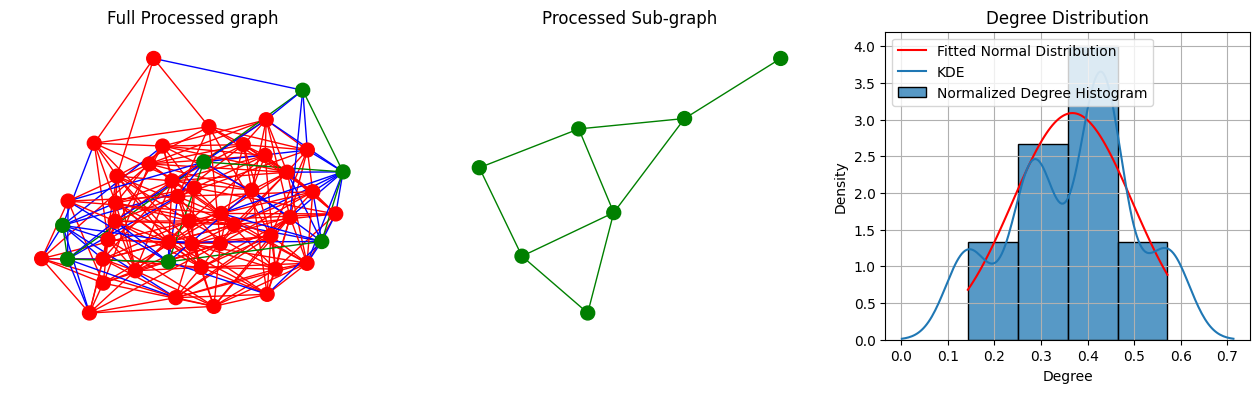

First 4 moments: ['0.3673', '0.1516', '0.0675', '0.0317', '0.0155', '0.0078']


In [29]:
# Transform to line
to_line = True
graph_processor_params = {'to_line': to_line}
graph_processor = GraphProcessor(params=graph_processor_params)
processed_G, gt_node_indicator_processed = graph_processor.pre_process(G,
                                                                       edge_indicator,
                                                                       w_indicator)
processed_G_sub = graph_processor.pre_process(G_sub)

# gt_node_indicator_line = np.array(
#     [edge_indicator[edge] for edge in processed_G.nodes()])

# Call the function to plot the graph with colors
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_graph_with_colors(G=processed_G,
                       distribution=gt_node_indicator_processed,
                       ax=axes[0], colorbar=False, title='Full Processed graph',
                       seed=seed,
                       draw_labels=False)
plot_graph_with_colors(G=processed_G_sub, ax=axes[1],
                       colorbar=False,
                       title='Processed Sub-graph', seed=seed, draw_labels=False)
# Plot degree distribution and compute first 4 moments
n_moments = 6
moments = plot_degree_distribution(processed_G_sub, n_moments=n_moments, ax=axes[2])
plt.show()
print(f"First 4 moments: {[f'{value:.4f}' for value in moments]}")

In [58]:
from subgraph_matching_via_nn.graph_classifier_networks.classification_layer.classification_layer import \
    SigmoidClassificationLayer, SoftmaxClassificationLayer, \
    TopkSoftmaxClassificationLayer, SquaredNormalizedClassificationLayer, \
    IdentityClassificationLayer, SpectralClassificationLayer
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    binary_penalty, graph_entropy, spectral_reg, graph_total_variation, \
    log_barrier_penalty

# --------- split -----------
# Assuming you have your graph G and subgraph G_sub defined
w_gt = (tensor(w_indicator)[:, None].float() / tensor(w_indicator).sum()).type(
    TORCH_DTYPE)
A_full = torch.from_numpy(nx.to_numpy_array(G)).type(TORCH_DTYPE)
A_sub = torch.from_numpy((nx.adjacency_matrix(G_sub)).toarray()).type(TORCH_DTYPE)
params = {}
params["solver_type"] = 'gd'  # 'gd', 'lbfgs'
params["maxiter"] = 5000
params["lr"] = 1e-5  # 0.0002 is good
params["n_moments"] = 10
params["m"] = len(processed_G_sub.nodes())
params["k_update_plot"] = 100
params[
    'spectral_op_type'] = 'SquaredProjectedHamiltonian'  # options: 'Laplacian',  'Adjacency', 'SquaredProjectedHamiltonian'
params["moment_type"] = "standardized_raw"
# options: 'central' ,'raw', 'standardized_raw', 'standardized_central'
params["reg_terms"] = [spectral_reg, binary_penalty]
params["reg_params"] = [10, 10]  # reg param  # 0.02  is good
params["quantile_level"] = (n - m) / m  # for binarization algorithm
evals, _ = torch.linalg.eigh(laplacian(A_sub))
params["n_eigs"] = min(len(processed_G_sub.nodes()), 10)
params['diagonal_scale'] = 2 * torch.max(evals)
params['zero_eig_scale'] = 10
params["second_eig"] = evals[1]

# Example usage
input_dim = len(processed_G.nodes())
hidden_dim = 20  # Hidden dimension
output_dim = len(processed_G.nodes())
last_layer = TopkSoftmaxClassificationLayer(k=params["m"], default_temp=0.5,
                                            learnable_temp=False)
#last_layer = SigmoidClassificationLayer()
#last_layer = SoftmaxClassificationLayer()
#last_layer = SquaredNormalizedClassificationLayer()
#last_layer = IdentityClassificationLayer()
#last_layer = SpectralClassificationLayer(indicator_scale=params["m"], diagonal_scale=params["diagonal_scale"])


# define node classifier networks
# 
node_classifier_network = NNNodeClassifierNetwork(input_dim=input_dim,
                                                  hidden_dim=hidden_dim,
                                                  output_dim=output_dim,
                                                  num_mid_layers=10,
                                                  classification_layer=last_layer
                                                  )
# node_classifier_network = IdentityNodeClassifierNetwork(output_dim=output_dim,
#                                                         classification_layer=last_layer)
# node_classifier_network = GCNNodeClassifierNetwork(num_node_features_input=1,
#                                       hidden_dim=hidden_dim,
#                                       num_node_features_output=1,
#                                       classification_layer=last_layer
#                            )
node_classifier_network.train_node_classifier(G_sub=G_sub, graph_generator=None)

# define embedding networks
embeddin_nns = []
moment_embedding_nn = MomentEmbeddingNetwork(n_moments=params["n_moments"],
                                             moments_type=params["moment_type"])

spectral_embedding_nn = SpectralEmbeddingNetwork(n_eigs=params["n_eigs"],
                                                 spectral_op_type=params[
                                                     'spectral_op_type'],
                                                 diagonal_scale=params[
                                                     'diagonal_scale'],
                                                 indicator_scale=params["m"],
                                                 zero_eig_scale=params[
                                                     "zero_eig_scale"])

embedding_nns = [
    #spectral_embedding_nn,
    moment_embedding_nn,
]
composite_nn = CompositeNeuralNetwork(node_classifier_network=node_classifier_network,
                                      embedding_networks=embedding_nns)
loss_fun = torch.nn.MSELoss()
embedding_metric_nn = EmbeddingMetricNetwork(loss_fun=loss_fun)


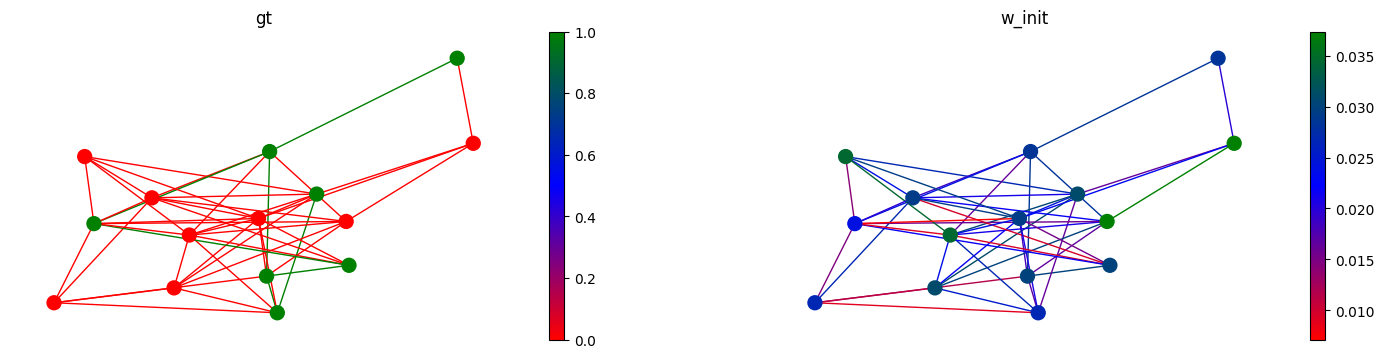

['0.9753', '1.0659', '1.1717', '1.3214', '1.5228', '1.7882', '2.1352', '2.5880', '3.1795'] : init standardized_raw moments
['0.9435', '1.1430', '1.3772', '1.7268', '2.2345', '2.9666', '4.0218', '5.5460', '7.7534'] : sub standardized_raw moments
init loss (no reg): 3.926494207195939
init full loss (with reg): 170.66429507080605


In [59]:
import torchsort

# --------- split here-----------


# Initialize the parameters
# TODO: move to function into compositeNN class
#x0 = w_gt.clone() + 0.01*torch.rand(w_gt.shape, dtype=TORCH_DTYPE)
A_full_processed = torch.from_numpy((nx.adjacency_matrix(processed_G)).toarray()).type(
    TORCH_DTYPE)
A_sub_processed = torch.from_numpy(
    (nx.adjacency_matrix(processed_G_sub)).toarray()).type(TORCH_DTYPE)

gt_indicator_tensor = tensor(gt_node_indicator_processed)[:, None].type(TORCH_DTYPE)
gt_indicator_tensor = gt_indicator_tensor / gt_indicator_tensor.sum()
x0 = (1 * gt_indicator_tensor.clone() +
      0.0 * (torch.rand(gt_indicator_tensor.shape, dtype=TORCH_DTYPE) - 0.5))
x0 = x0 / torch.sum(x0)

#composite_nn.node_classifier_network.init_params(default_weights=x0)
w_init = composite_nn.node_classifier_network(A=A_full_processed,
                                              params=params).detach().numpy()
w_init_dict = dict(zip(processed_G.nodes(), w_init))

# print(f"x0 = {x0.detach().numpy().T}")
# print(f"gt = {edge_mask_gt.detach().numpy().T}")
# print(f"nn params = {w_init.T}")

fig, axes = plt.subplots(1, 2, figsize=[18, 4])
gt_indicator = edge_indicator if to_line else w_indicator
w_init_indicator = w_init_dict if to_line else np.array(list(w_init_dict.values()))

plot_graph_with_colors(G=G, title='gt', distribution=gt_indicator,
                       ax=axes[0], seed=seed)
plot_graph_with_colors(G=G, title='w_init', distribution=w_init_indicator,
                       ax=axes[1], seed=seed)

plt.show()

# compute loss and embedding at init

embeddings_sub = composite_nn.embed(A=A_sub_processed.detach().type(TORCH_DTYPE),
                                    w=uniform_dist(A_sub_processed.shape[0]).detach())

embeddings_full, w = composite_nn(A=A_full_processed, params=params)
loss = embedding_metric_nn(embeddings_full=embeddings_full,
                           embeddings_subgraph=embeddings_sub)
embeddings_gt = composite_nn.embed(A=A_full_processed.detach().type(TORCH_DTYPE),
                                   w=gt_indicator_tensor)

idx = 0
print(
    f"{[f'{value:.4f}' for value in embeddings_full[idx]]} : init {embedding_nns[idx].embedding_type}")
print(
    f"{[f'{value:.4f}' for value in embeddings_sub[idx]]} : sub {embedding_nns[idx].embedding_type}")

print(f"init loss (no reg): {loss}")  # without regularization
# reg = params["reg_term"](A_full_processed, w, params)
reg = torch.stack(
    [reg_param * reg_term(A_full_processed, w, params) for reg_param, reg_term in
     zip(params["reg_params"], params["reg_terms"])]).sum()
full_loss = loss + reg
print(f"init full loss (with reg): {full_loss}")  # with regularization

w_all = []

# --------- split here-----------


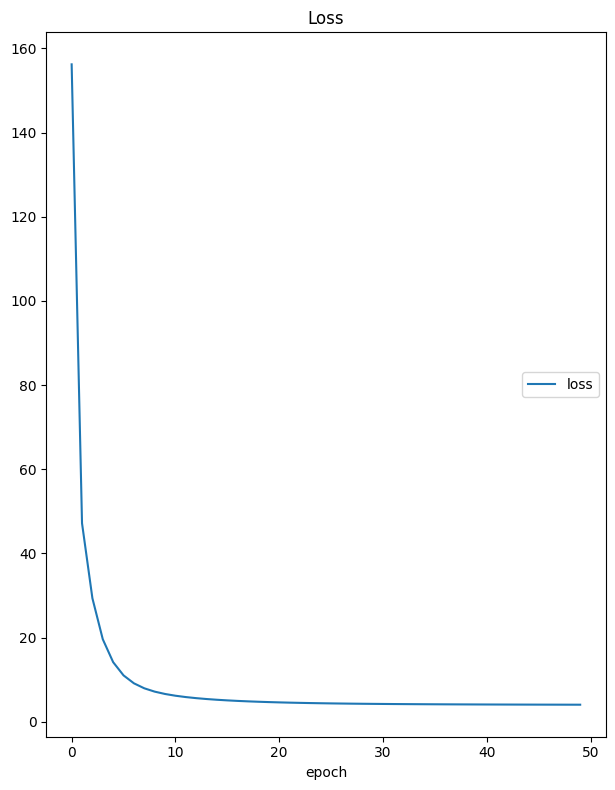

 99%|█████████▊| 4933/5000 [00:23<00:00, 224.29it/s]

Loss
	loss             	 (min:    4.067, max:  156.198, cur:    4.067)


100%|██████████| 5000/5000 [00:23<00:00, 214.88it/s]

Iteration 4999, Data: 3.4835011046520488
Iteration 4999, Reg: 0.5798079880645508
Iteration 4999, Data + rho * Reg: 4.063309092716599
0


In [60]:

num_rand_exp = 1
plt.figure(figsize=(3, 2))
for k in range(num_rand_exp):
    # TODO: how do I initialize all network params?
    # params["x0"] = x0/torch.sum(x0)
    # params["x0"] = w_gt.T

    # x0 = (0*gt_indicator_tensor.clone() + 1 * (torch.rand(gt_indicator_tensor.shape, dtype=TORCH_DTYPE)-0.5))
    # x0 = x0/torch.sum(x0)
    # composite_nn.node_classifier_network.init_params(default_weights=x0)

    nn_subgraph_localization(G=G,
                             G_sub=G_sub,
                             composite_nn=composite_nn,
                             embedding_metric_nn=embedding_metric_nn,
                             graph_processor=graph_processor,
                             params=params,
                             )
    opt_mask = node_classifier_network(A=A_full_processed, params=params).detach()
    w_star = opt_mask.numpy()

    #w_th = tensor(list( binarize(processed_G, w_star, params, binarization_type).values()))
    # x0 = w_star-np.min(w_star)
    # x0 = tensor(x0/x0.sum())
    # composite_nn.node_classifier_network.init_params(default_weights=x0)

    w_all.append(w_star)

    print(k)


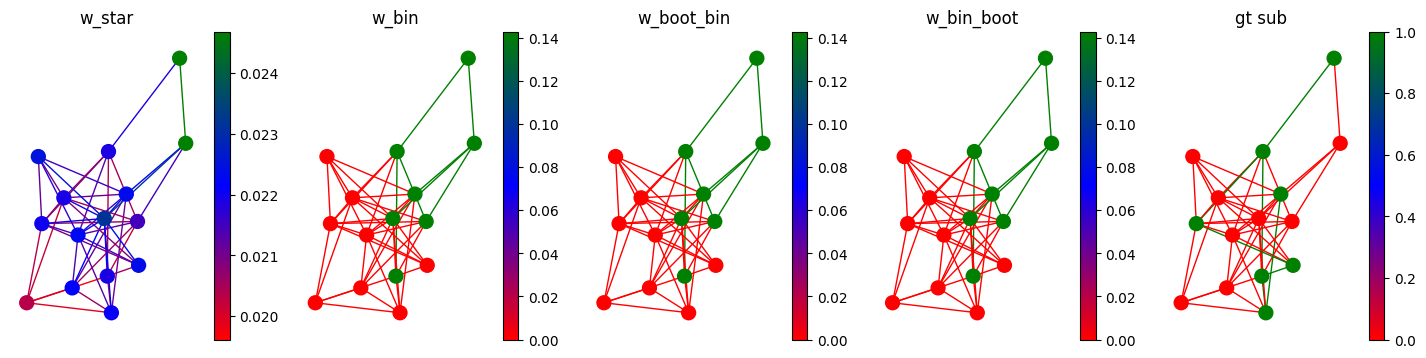

In [61]:
from subgraph_matching_via_nn.utils.utils import top_m
import scipy as sp


# def binarize(graph: nx.graph, w: np.array, params, type='top_m'):
#     if type == 'k_means':
#         w_th, centroids = kmeans1d.cluster(w, k=2)
#         w_th = np.array(w_th)[:, None]
#     elif type == 'top_m':
#         w_th = top_m(w, params["m"])
#     elif type == 'quantile':
#         w_th = (w > np.quantile(w, params["quantile_level"]))
#         w_th = np.array(w_th, dtype=np.float64)
#     elif type == 'diffusion':
#         A = (nx.adjacency_matrix(graph)).toarray()
#         D = np.diag(A.sum(axis=1))
#         L = D - A
#         # # Eigenvalue decomposition of the Laplacian
#         # eigenvalues, eigenvectors = np.linalg.eigh(L)
# 
#         # Generalized eigenvalue decomposition of the Random Walk Laplacian
#         # eigenvalues, eigenvectors = np.linalg.eigh(L)
#         eigenvalues, eigenvectors = sp.linalg.eigh(L, D)
# 
#         k = 10
# 
#         # Generate k logarithmically spaced values of t from a large to small value
#         max_t = 10  # Change this to your desired maximum value
#         min_t = 0.01  # Change this to your desired minimum value
#         t_values = np.logspace(np.log10(max_t), np.log10(min_t), k)
# 
#         w_th = w
#         for t in t_values:
#             # Apply the heat kernel using matrix exponentiation
#             heat_matrix = eigenvectors @ np.diag(
#                 np.exp(-t * eigenvalues)) @ eigenvectors.T
#             heat_w = heat_matrix @ w_th
# 
#             # Binarize by keeping the largest m components
#             w_th = top_m(heat_w, params["m"])
#     elif type == 'zoomout':
#         A = (nx.adjacency_matrix(graph)).toarray()
#         D = np.diag(A.sum(axis=1))
#         L = D - A
# 
#         # Generalized eigenvalue decomposition of the Random Walk Laplacian
#         # eigenvalues, eigenvectors = np.linalg.eigh(L)
#         eigenvalues, eigenvectors = sp.linalg.eigh(L, D)
# 
#         w_th = w
#         for i in range(2, A.shape[0]):
#             # Apply the heat kernel using matrix exponentiation
#             heat_w = eigenvectors[:, :i] @ eigenvectors[:, :i].T @ w_th
# 
#             # Binarize by keeping the largest m components
#             w_th = top_m(heat_w, params["m"])
# 
#     elif type == 'nonlinear_zoomout':
#         A = (nx.adjacency_matrix(graph)).toarray()
#         D = np.diag(A.sum(axis=1))
#         L = D - A
#         w_th = w
#         heat_w = w
#         for i in range(2, A.shape[0]):
#             E = graph_edit_matrix(A, 1 - params["m"] * w_th)
#             Ae = A - E
# 
#             De = np.diag(Ae.sum(axis=1))
#             Le = De - Ae
# 
#             # Generalized eigenvalue decomposition of the Random Walk Laplacian
#             eigenvalues, eigenvectors = np.linalg.eigh(Le)
#             #eigenvalues, eigenvectors = sp.linalg.eigh(Le, De)
#             # Apply the heat kernel using matrix exponentiation
#             heat_w = eigenvectors[:, :i] @ eigenvectors[:, :i].T @ w_th
# 
#             # Binarize by keeping the largest m components
#             w_th = top_m(heat_w, params["m"])
# 
#     w_th = w_th / w_th.sum()
#     w_th_dict = dict(zip(graph.nodes(), w_th))
#     return w_th_dict


#from subgraph_matching_via_nn.graph_processors.graph_processors import binarize
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor

binarize = GraphProcessor.binarize

binarization_type = 'zoomout'

A_full_processed = torch.from_numpy(
    nx.to_numpy_array(graph_processor.pre_process(G))).type(TORCH_DTYPE)
A_sub_processed = torch.from_numpy(
    nx.to_numpy_array(graph_processor.pre_process(G_sub))).type(TORCH_DTYPE)

opt_mask = node_classifier_network(A=A_full_processed, params=params).detach()
w_star = opt_mask.numpy()
w_star_dict = dict(zip(processed_G.nodes(), w_star))

w_bin_dict = binarize(processed_G, w_star, params, binarization_type)

w_boot = np.mean(np.array(w_all), axis=0)
w_boot = w_boot / w_boot.sum()
w_boot_dict = dict(zip(processed_G.nodes(), w_boot))

w_boot_dict_bin = binarize(processed_G, w_boot, params, binarization_type)

w_binarize_boot_dict = binarize(processed_G, np.median(
    np.array(
        [list(binarize(processed_G, w, params, binarization_type).values()) for w in
         w_all]), axis=0),
                                params, binarization_type)

fig, axes = plt.subplots(1, 5, figsize=[18, 4])

indicator_w_star = w_star_dict if to_line else w_star
indicator_w_th = w_bin_dict if to_line else np.array(list(w_bin_dict.values()))
indicator_w_boot_th = w_boot_dict_bin if to_line else np.array(
    list(w_boot_dict_bin.values()))
indicator_w_binarize_boot = w_binarize_boot_dict if to_line else np.array(
    list(w_binarize_boot_dict.values()))

plot_graph_with_colors(G=G, distribution=indicator_w_star, title='w_star',
                       ax=axes[0], seed=seed)
plot_graph_with_colors(G=G, distribution=indicator_w_th, title='w_bin',
                       ax=axes[1], seed=seed)
plot_graph_with_colors(G=G, distribution=indicator_w_boot_th,
                       title='w_boot_bin',
                       ax=axes[2], seed=seed)
plot_graph_with_colors(G=G, distribution=indicator_w_binarize_boot,
                       title='w_bin_boot',
                       ax=axes[3], seed=seed)
plot_graph_with_colors(G=G, distribution=gt_indicator, title='gt sub', ax=axes[4],
                       seed=seed)
plt.show()

['0.9435', '1.1430', '1.3772', '1.7268', '2.2345', '2.9666', '4.0218', '5.5460', '7.7534'] : sub standardized_raw moments 
['0.9435', '1.1430', '1.3772', '1.7268', '2.2345', '2.9666', '4.0218', '5.5460', '7.7534'] : gt standardized_raw moments 
['0.9763', '1.0641', '1.1699', '1.3241', '1.5385', '1.8303', '2.2242', '2.7549', '3.4706'] : est standardized_raw moments
['0.9800', '1.0567', '1.1505', '1.2850', '1.4667', '1.7046', '2.0111', '2.4019', '2.8967'] : est standardized_raw moments bin
['0.9800', '1.0567', '1.1505', '1.2850', '1.4667', '1.7046', '2.0111', '2.4019', '2.8967'] : est standardized_raw moments boot_bin
['0.9800', '1.0567', '1.1505', '1.2850', '1.4667', '1.7046', '2.0111', '2.4019', '2.8967'] : est standardized_raw moments bin_boot_bin

to_line = True

data_term = 3.4835011046520488, reg_params = [10, 10], reg_terms = ['spectral_reg', 'binary_penalty']
data_term_ref = 1.314768175368353e-31, reg_param = [10, 10], reg_terms = ['spectral_reg', 'binary_penalty']

Remark: embed

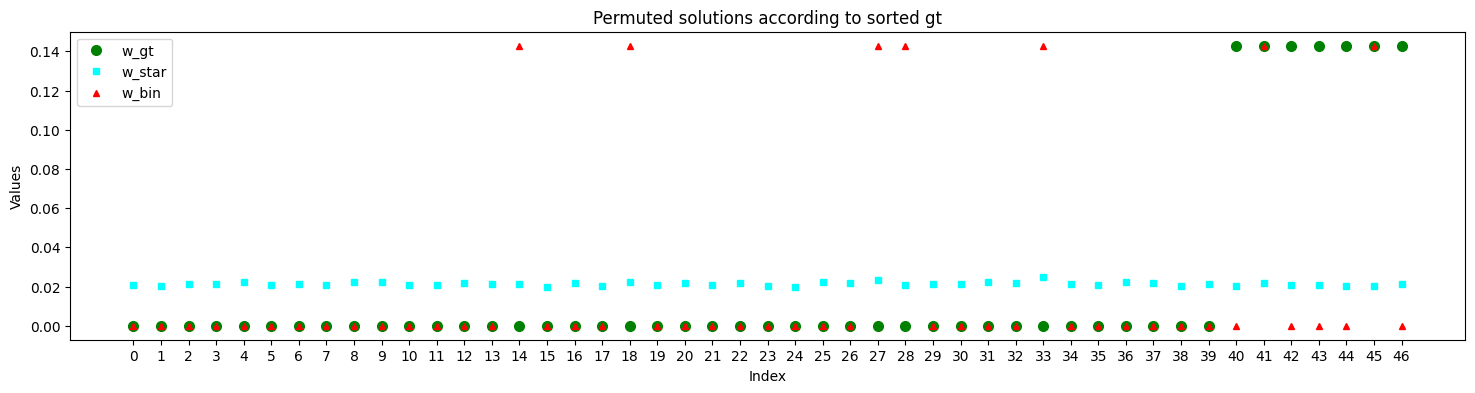

In [62]:
idx = 0  # to choose which embedding to plot

# turn indicator into tensor and normalize to get distribution on nodes of line graph
gt_node_distribution_processed = tensor(gt_node_indicator_processed)[:, None].type(
    TORCH_DTYPE)
gt_node_distribution_processed = gt_node_distribution_processed / torch.sum(
    gt_node_distribution_processed)
embeddings, _ = composite_nn(A=A_full_processed, params=params)
embeddings_sub = composite_nn.embed(A=A_sub_processed.detach().type(TORCH_DTYPE),
                                    w=uniform_dist(A_sub_processed.shape[0]).detach())
embeddings_gt = composite_nn.embed(A=A_full_processed.detach().type(TORCH_DTYPE),
                                   w=gt_node_distribution_processed)
est_embedding = embedding_nns[idx](w=tensor(w_star, requires_grad=False),
                                   A=A_full_processed.detach()).type(TORCH_DTYPE)
est_embedding_bin = embedding_nns[idx](
    w=tensor(list(w_bin_dict.values()), requires_grad=False),
    A=A_full_processed).type(TORCH_DTYPE)
est_embedding_boot_bin = embedding_nns[idx](
    w=tensor(list(w_boot_dict_bin.values()), requires_grad=False),
    A=A_full_processed).type(TORCH_DTYPE)
est_embedding_bin_boot_bin = embedding_nns[idx](
    w=tensor(list(w_binarize_boot_dict.values()), requires_grad=False),
    A=A_full_processed).type(TORCH_DTYPE)

print(
    f"{[f'{value:.4f}' for value in embeddings_sub[idx]]} : sub {embedding_nns[idx].embedding_type} ")
print(
    f"{[f'{value:.4f}' for value in embeddings_gt[idx]]} : gt {embedding_nns[idx].embedding_type} ")
print(
    f"{[f'{value:.4f}' for value in est_embedding]} : est {embedding_nns[idx].embedding_type}")
print(
    f"{[f'{value:.4f}' for value in est_embedding_bin]} : est {embedding_nns[idx].embedding_type} bin")
print(
    f"{[f'{value:.4f}' for value in est_embedding_boot_bin]} : est {embedding_nns[idx].embedding_type} boot_bin")
print(
    f"{[f'{value:.4f}' for value in est_embedding_bin_boot_bin]} : est {embedding_nns[idx].embedding_type} bin_boot_bin")

loss = embedding_metric_nn(embeddings, embeddings_sub)
ref_loss = embedding_metric_nn(embeddings_gt,
                               embeddings_sub)  # for comparison, that's as good as we can get. embeddings_gt and embeddings_sub might differ if we don't transform to line graph because node indicator can at best give a superset of the edges of the subgraph.

reg_terms_names = [reg_terms.__name__ for reg_terms in params['reg_terms']]

print(f"\n{to_line = }")
print(
    f"\ndata_term = {loss}, reg_params = {params['reg_params']}, reg_terms = {reg_terms_names}")

print(
    f"data_term_ref = {ref_loss}, reg_param = {params['reg_params']}, reg_terms = {reg_terms_names}")
print(
    f"\nRemark: embeddings_gt and embeddings_sub might differ if we don't transform to line graph because node indicator can at best give a superset of the edges of the subgraph.")

fig, ax = plt.subplots(1, 1, figsize=[18, 4])
plot_indicator(
    [gt_node_distribution_processed, w_star, np.array(list(w_bin_dict.values()))],
    ['w_gt', 'w_star', 'w_bin'], ax)